Setups

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, filters, morphology
from skimage.util import img_as_float
from scipy import signal

Canny:

1. Smooth image with Gaussian filter
2. Compute gradient magnitude and angle (Sobel, Prewitt, ...)
3. Apply non-maximum suppression
4. Double thresholding for potential edges
5. Track edges by hysteresis

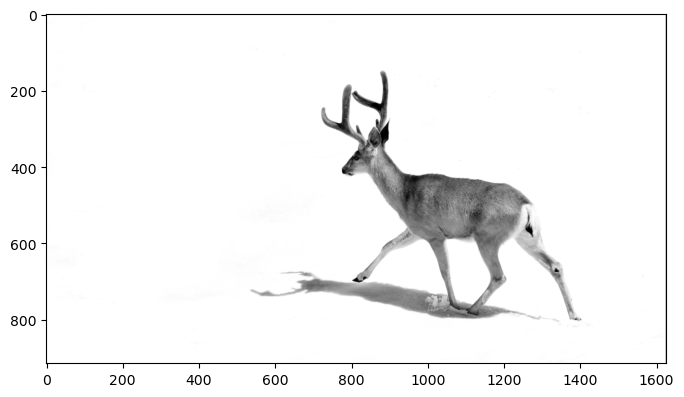

In [2]:
#load the image, downsampling by factor of 2 to speed up
image = color.rgb2gray(img_as_float(io.imread('data/resources/deer.jpg')))
image = transform.downscale_local_mean(image, (2, 2))
#plot
plt.figure(figsize=(8, 10))
plt.imshow(image, cmap='gray')
plt.show()

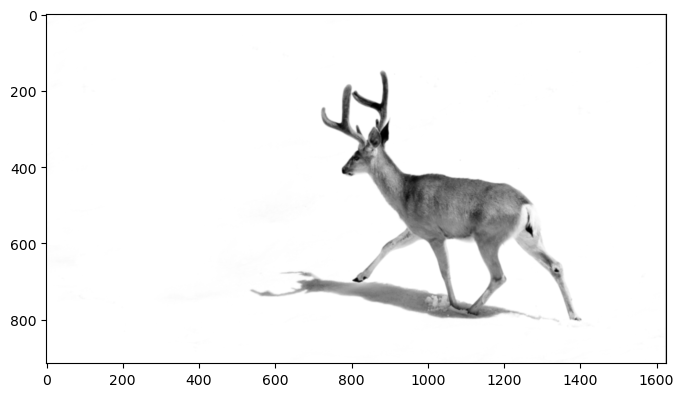

In [3]:
#1.smooth by Gaussian
def smooth_gaussian(image, sigma):
    return filters.gaussian(image, sigma=sigma)

image_smooth = smooth_gaussian(image, sigma=1)
#plot
plt.figure(figsize=(8, 10))
plt.imshow(image_smooth, cmap='gray')
plt.show()

Write a function `sobel_gradient(image)` that returns the gradient magnitude and angle of the image using Sobel filters.

The gradient magnitude $g[m,n]$ is obtained by combining the filtered images $y_0[m,n] = x[m,n] * h_0[m,n]$ and $y_{90}[m, n] = x[m,n] * h_{90}[m,n]$ as

$$g[m,n] = \sqrt{y_0^2[m,n] + y_{90}^2[m,n]},$$

the gradient angle is obtained as

$$\varphi[m,n] = \text{arctan2}(y_0[m,n], y_{90}[m,n]). $$

Normalize the gradient magnitude to a range of 0 to 1, then return both the normalized gradient magnitude and the gradient angle.

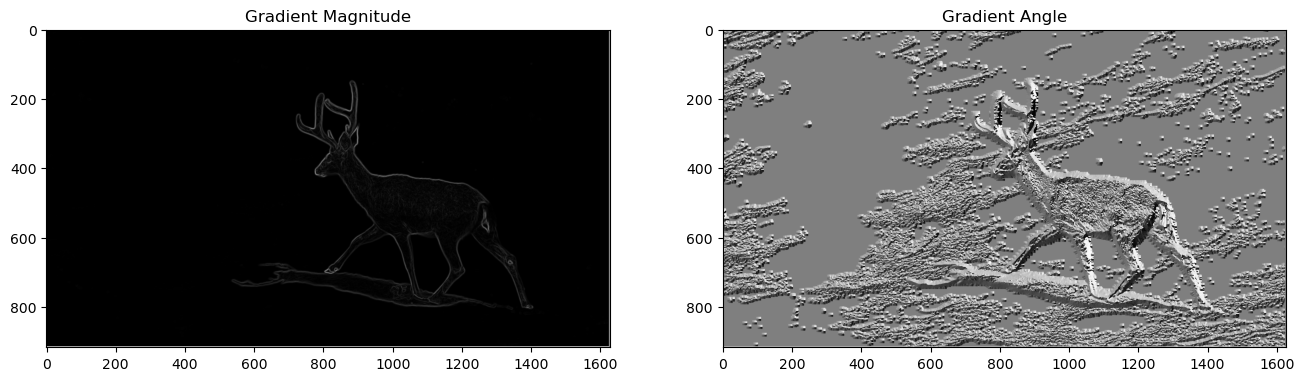

In [4]:
def sobel_gradient(image):
    sobel_0 = np.array([[-1, -2, -1],
                         [0, 0, 0],
                         [1, 2, 1]])
    sobel_90 = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
    image_sobel_0 = signal.convolve2d(image, sobel_0)
    image_sobel_90 = signal.convolve2d(image, sobel_90)
    
    gradient_magnitude = np.sqrt(np.square(image_sobel_0) + np.square(image_sobel_90))
#normalize
    gradient_magnitude = gradient_magnitude / np.max(gradient_magnitude)
    gradient_angle = np.arctan2(image_sobel_0, image_sobel_90)
    return gradient_magnitude, gradient_angle

image_gradient_magnitude, image_gradient_angle = sobel_gradient(image_smooth)

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].imshow(image_gradient_magnitude, cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Gradient Magnitude")
axs[1].imshow(image_gradient_angle, cmap='gray')
axs[1].set_title("Gradient Angle")
plt.show()

non-maximum suppression

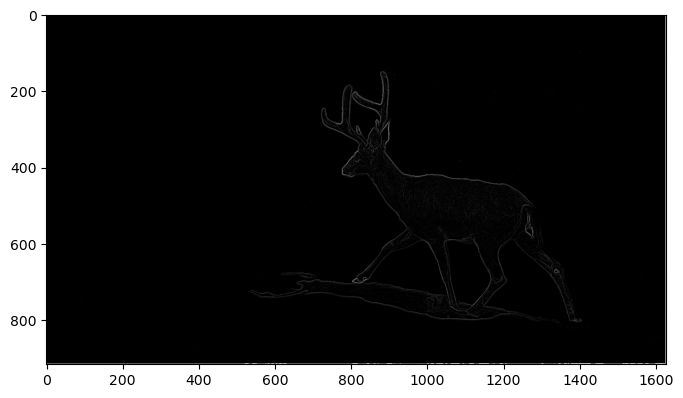

In [5]:
def non_maximum_suppression(gradient_magnitude, gradient_angle):
    # value = 0 -> angle = 0
    # value = 1 -> angle = pi/4
    # value = 2 -> angle = pi/2
    # value = 3 -> angle = 3pi/4
    gradient_angle_quantized = np.round(gradient_angle / (np.pi / 4)).astype(int) % 4
    #initialize the gradient magnitude
    gradient_magnitude_suppressed = gradient_magnitude.copy()
    # The edge direction offsets as (y_offset, x_offset) for each edge direction
    # Offset at index i corresponds to angle with value i (e.g. index = 1 -> value = 1 -> angle = pi/4)
    edge_dir_offsets = [(0, 1), (1, 1), (1, 0), (1, -1)]
    
    # Pad the original gradient magnitude so we don't get problems at the borders.
    gradient_magnitude_padded = np.pad(gradient_magnitude, 1)
    
    # Loop through all edge directions
    for edge_dir, offset in enumerate(edge_dir_offsets):
        # Get all indices as [[y0, x0], [y1, x1], ...] where the quantized gradient angle matches the currently regarded edge direction.
        indices = np.argwhere(gradient_angle_quantized == edge_dir)
        
        # Add and substract the offset as specified in the edge direction offsets to the indices to get the indices
        # required for checking whether a pixel value is kept or not.
        indices_plus = np.hstack((indices[:, 0].reshape(-1, 1) + offset[0], indices[:, 1].reshape(-1, 1) + offset[1]))
        indices_minus = np.hstack((indices[:, 0].reshape(-1, 1) + offset[0], indices[:, 1].reshape(-1, 1) + offset[1]))
        
        # Check whether the pixel value at index should be kept. For each regarded pixel, this is only the case if the gradient magnitude value at the pixel position
        # is larger than the gradient magnitude value of its neighbors. Thereby, the neighbors are specified using the edge direction offset, which is based on the
        # gradient angle. As after this offset, pixels might be addressed that are out-of-bounds, the padded gradient magnitude is accessed to avoid accessing invalid memory.
        condition_keep_plus = (gradient_magnitude[indices[:, 0], indices[:, 1]] > gradient_magnitude_padded[indices_plus[:, 0] + 1, indices_plus[:, 1] + 1])
        condition_keep_minus = (gradient_magnitude[indices[:, 0], indices[:, 1]] > gradient_magnitude_padded[indices_minus[:, 0] + 1, indices_minus[:, 1] + 1])
        condition_keep = condition_keep_plus & condition_keep_minus
        
        # The entries in the non-maximum suppressed gradient magnitude are either taken over from the original gradient magnitude (if condition_keep==True)
        # or replaced by 0 (if condition_keep==False)
        gradient_magnitude_suppressed[indices[:, 0], indices[:, 1]] = np.where(condition_keep, gradient_magnitude[indices[:, 0], indices[:, 1]], 0)
    
    return gradient_magnitude_suppressed
    
image_gradient_magnitude_suppressed = non_maximum_suppression(image_gradient_magnitude, image_gradient_angle)
#plot
plt.figure(figsize=(8, 10))
plt.imshow(image_gradient_magnitude_suppressed,cmap='gray', vmin=0, vmax=1)
plt.show()

Double Thresholding

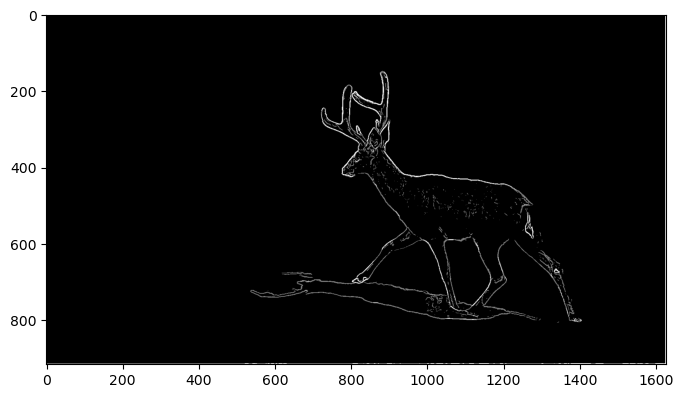

In [6]:
def double_thresholding(gradient_magnitude, threshold_low, threshold_high):
    gradient_magnitude_thresholded = np.where(gradient_magnitude > threshold_high, 1, 0.5)
    gradient_magnitude_thresholded = np.where(gradient_magnitude < threshold_low, 0, gradient_magnitude_thresholded)
    return gradient_magnitude_thresholded

threshold_high = 0.2
image_potential_edgemap = double_thresholding(image_gradient_magnitude_suppressed, 0.4 * threshold_high, threshold_high)

plt.figure(figsize=(8, 10))
plt.imshow(image_potential_edgemap, cmap='gray')
plt.show()

Edge Hysteresis: determinate whether its a strong edge or weak edge

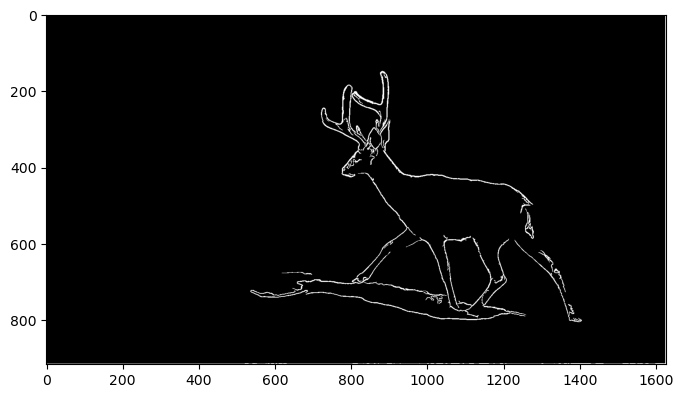

In [7]:
def edge_hysteresis(potential_edgemap):
    height, width = potential_edgemap.shape
    
    should_stop = False#set it as false at first
    while not should_stop:
        strong_edgemap_dilated = morphology.binary_dilation(potential_edgemap == 1, morphology.square(3))
        #==1 creat bool array same size as the pic, picking out the true values.(3)means a 3x3 mask
        update_mask = strong_edgemap_dilated & (potential_edgemap == 0.5)
        #find the intersection
        potential_edgemap[update_mask] = 1
        if np.all(update_mask == False):
            should_stop = True#then out the loop
    potential_edgemap[potential_edgemap == 0.5] = 0
    return potential_edgemap

image_edgemap = edge_hysteresis(image_potential_edgemap)

plt.figure(figsize=(8, 10))
plt.imshow(image_edgemap, cmap='gray')
plt.show()

put all together

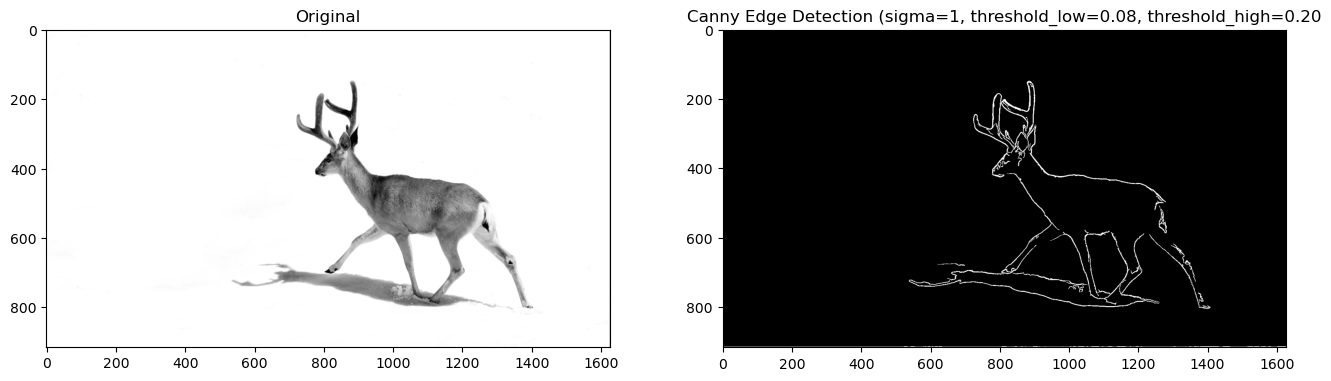

In [10]:
def canny_edge_detection(image, sigma, threshold_low, threshold_high):
    image_gaussian = smooth_gaussian(image, sigma)
    gradient_magnitude, gradient_angle = sobel_gradient(image_gaussian)
    gradient_magnitude_suppressed = non_maximum_suppression(gradient_magnitude, gradient_angle)
    potential_edgemap = double_thresholding(gradient_magnitude_suppressed, threshold_low, threshold_high)
    edgemap = edge_hysteresis(potential_edgemap)
    return edgemap

image = color.rgb2gray(img_as_float(io.imread("data/resources/deer.jpg")))
image = transform.downscale_local_mean(image, (2, 2))

sigma = 1
threshold_high = 0.2
threshold_low = 0.4 * threshold_high
edgemap_canny = canny_edge_detection(image, sigma, threshold_low, threshold_high)

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].imshow(image, cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Original")
axs[1].imshow(edgemap_canny, cmap='gray')
axs[1].set_title(f"Canny Edge Detection (sigma={sigma}, threshold_low={threshold_low:.2f}, threshold_high={threshold_high:.2f}")
plt.show()